### Estimate EEG Data without Artifcats

In [152]:
%matplotlib inline

In [153]:
import mne
import numpy as np
from mne.datasets import sample
import matplotlib.pyplot as plt

#### Load Forward Model

In [125]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
info = mne.io.read_info(raw_fname) 
fwd = mne.read_forward_solution("sample_forward_model")

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Reading forward solution from sample_forward_model...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


<ipython-input-125-4a7190ffba04>:4: RuntimeWarning: This filename (sample_forward_model) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution("sample_forward_model")


In [126]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


In [127]:
leadfield = fwd_fixed['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 60 sensors x 7498 dipoles


In [137]:
# n_dipoles = leadfield.shape[1]
# vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
# stc = mne.SourceEstimate(1e-9 * np.eye(n_dipoles), vertices, tmin=0., tstep=1)
# leadfield = mne.apply_forward(fwd_fixed, stc, info).data / 1e-9

#### Use Forward Model to Estimate Data

In [134]:
n_sensors = 60
n_times = 256
time_step = 1

Random source

In [138]:
z = np.dot(np.random.randn(n_dipoles, n_sensors), np.random.randn(n_sensors, n_times)) * 1e-9

In [139]:
# n_dipoles = leadfield.shape[1]
vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
# z = np.random.randn(n_dipoles, n_dipoles) * 1e-9
stc = mne.SourceEstimate(z, vertices, tmin=0., tstep=time_step)
leadfield = mne.apply_forward(fwd_fixed, stc, info).data# / np.sum(z, axis=1)

Projecting source estimate to sensor space...
[done]


In [140]:
leadfield.shape

(60, 256)

In [142]:
leadfield = mne.apply_forward(fwd_fixed, stc, info)

Projecting source estimate to sensor space...
[done]


In [143]:
leadfield

<Evoked  |  '' (mean, N=1), [0, 255] sec, 60 ch, ~3.2 MB>

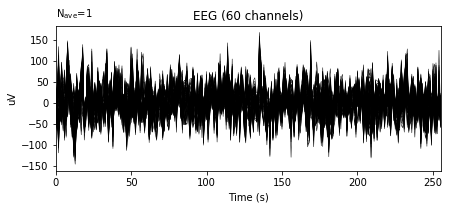

In [149]:
fig = leadfield.plot(exclude=(), time_unit='s')

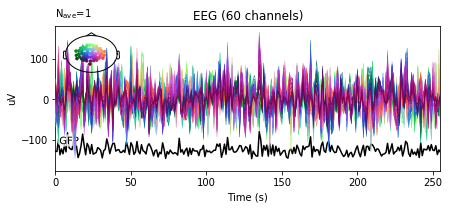

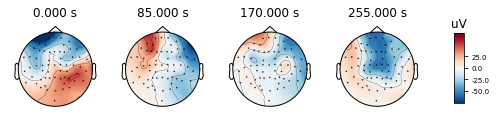

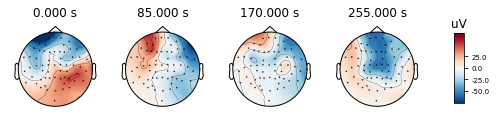

In [158]:
picks = mne.pick_types(leadfield.info, meg=False, eeg=True, eog=False)
leadfield.plot(spatial_colors=True, gfp=True, picks=picks, time_unit='s')
leadfield.plot_topomap(time_unit='s')